✅ All libraries imported successfully!
PyTorch version: 2.9.1+cpu
CUDA available: False
Using device: cpu
✅ Paths configured
Loading clinical and imaging data...

Merged data shape: (111, 36)

Columns:
['Accession', 'Patient ID', 'Age at BM Dx', 'Sex', 'Pack-Year Smoking Hx', 'NIH Racial Category', 'KPS at BM Dx', 'Age at Resection', 'Size of Dominant Lesion', 'Number of BM Lesions at Dx', 'Location of Lesion', 'Histologic Subtype', 'GPA Histology Class', 'Presence of Extracranial Mets at Dx (1 = Yes; 0 = No)', 'EGFR Status (1 = Mutation; 0 = WT)', 'ALK Status (1 = Mutation; 0 = WT)', 'PD-L1 Status (1 = Mutation; 0 = WT)', 'Sperduto GPA', 'patientID', 'Original Scan Facility', 'Scanner vendor', 'Scanner model', 'field_strength', '2D_3D_acquisition', 'FLAIR-Available', 'T1CE-Available', 'flair_slice_thickness', 'flair_spacing', 'flair_repetition_time', 'flair_echo_time', 'flair_spin_echo', 't1ce_slice_thickness', 't1ce_spacing', 't1ce_repetition_time', 't1ce_echo_time', 't1ce_spin_echo'

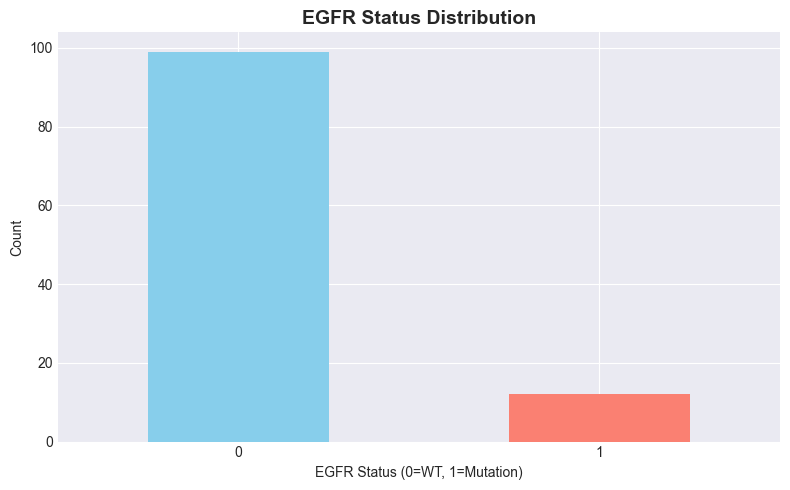

Creating data inventory...

DATA INVENTORY SUMMARY
Total patients with EGFR labels: 111
Patients with MRI: 111
  - T1CE: 107
  - FLAIR: 104
  - Segmentation: 111
Patients with Histology: 0
Patients with BOTH MRI + Histology: 0

EGFR Distribution:
egfr_status
0    99
1    12
Name: count, dtype: int64


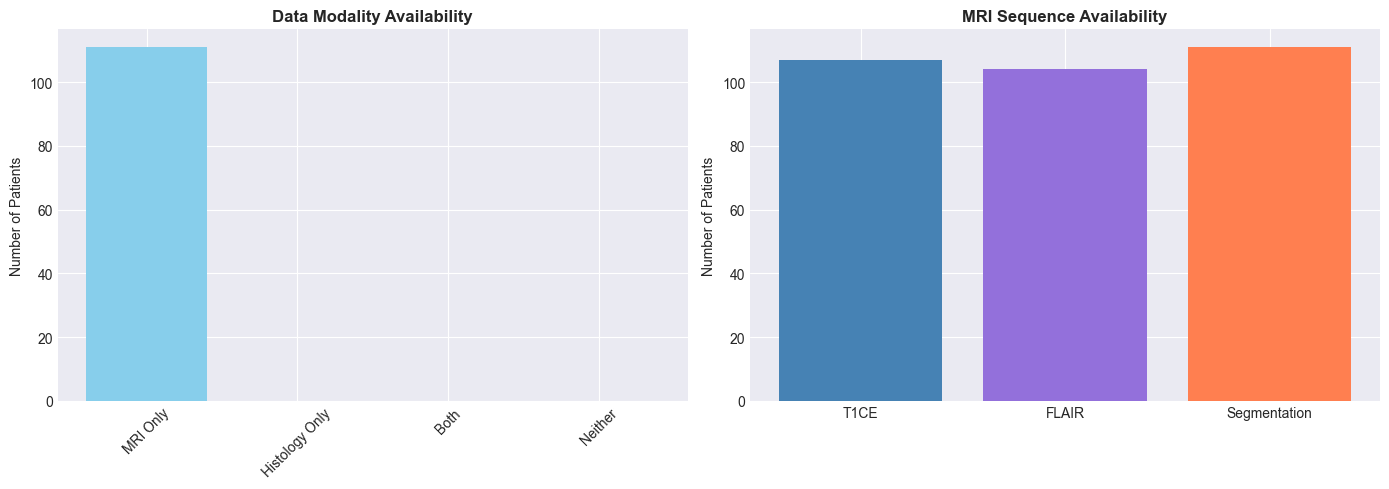

Creating stratified data splits...
Patients with complete data (MRI + Histology): 0

⚠️ WARNING: Very few patients with complete data!
Using patients with at least MRI data for analysis...
Patients with MRI data: 111

Dataset splits:
  Train: 77 patients
  Val: 11 patients
  Test: 23 patients

EGFR distribution:
  Train: {0: 68, 1: 9}
  Val: {0: 10, 1: 1}
  Test: {0: 21, 1: 2}

✅ Data preparation complete!
Extracting clinical features...
✅ Clinical features extracted: 10 features
Feature names: ['age', 'smoking', 'kps', 'lesion_size', 'num_lesions', 'gpa_score', 'sex', 'extracranial_mets', 'alk', 'pdl1']

TRAINING CLINICAL BASELINE MODELS

Training Logistic Regression...
  Test Accuracy: 0.7391
  Test AUC-ROC: 0.5000
  Test AUC-PR: 0.1526
  Test F1: 0.0000

Training Random Forest...
  Test Accuracy: 0.9130
  Test AUC-ROC: 0.7619
  Test AUC-PR: 0.2111
  Test F1: 0.0000

Training Gradient Boosting...
  Test Accuracy: 0.8696
  Test AUC-ROC: 0.7857
  Test AUC-PR: 0.2500
  Test F1: 0.0000



In [ ]:
# EGFR Multimodal Pipeline - Complete Jupyter Notebook
# ====================================================
# Run this notebook cell by cell in VSCode
# Complete implementation for EGFR mutation prediction

# %% [markdown]
# # EGFR Mutation Prediction: Complete Multimodal Learning Pipeline
# 
# ## Pipeline Overview:
# 1. Data Loading & Preparation
# 2. Clinical Baseline Models
# 3. MRI-based Deep Learning
# 4. Histopathology-based MIL
# 5. Multimodal Fusion
# 6. Comprehensive Evaluation
# 7. Visualization & Reporting

# %%
# Install required packages (uncomment if needed)
# !pip install torch torchvision numpy pandas scikit-learn nibabel opencv-python Pillow matplotlib seaborn tqdm openpyxl scipy statsmodels

# %%
# Import all required libraries
import os
import sys
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm

import json

# Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms

# Medical Imaging
import nibabel as nib
import cv2
from PIL import Image

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    f1_score,
    roc_curve,
    precision_recall_curve,
    confusion_matrix,
    classification_report,
)

from sklearn.calibration import calibration_curve


# Statistical tests
from scipy import stats
from scipy.stats import chi2_contingency

print("✅ All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# %%
# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# %% [markdown]
# ## 1. Data Loading & Preparation

# %%
# Configure your data paths
CLINICAL_IMAGING_PATH = r"D:\paper\external.xlsx"
MRI_BASE_PATH = r"C:\Users\Shahinur\Downloads\PKG_Dataset\PKG - Brain-Mets-Lung-MRI-Path-Segs_radiology_images\Brain-Mets-Lung-MRI-Path-Segs"
HISTOLOGY_BASE_PATH = r"C:\Users\Shahinur\Downloads\PKG_Dataset\PKG - Brain-Mets-Lung-MRI-Path-Segs_histopathology images\data"

# Create output directories
os.makedirs('models', exist_ok=True)
os.makedirs('results/figures', exist_ok=True)
os.makedirs('results/reports', exist_ok=True)

print("✅ Paths configured")

# %%
# Load merged clinical-imaging data
print("Loading clinical and imaging data...")

merged_df = pd.read_excel(CLINICAL_IMAGING_PATH)

# Clean column names
merged_df.columns = merged_df.columns.str.strip()

print(f"\nMerged data shape: {merged_df.shape}")
print("\nColumns:")
print(merged_df.columns.tolist())

# %%
# Display EGFR distribution
egfr_col = None
for col in merged_df.columns:
    if 'EGFR' in col.upper() and 'STATUS' in col.upper():
        egfr_col = col
        break

if egfr_col:
    print(f"\nEGFR Status column: '{egfr_col}'")
    print("\nEGFR Distribution:")
    print(merged_df[egfr_col].value_counts())
    
    # Plot distribution
    plt.figure(figsize=(8, 5))
    egfr_counts = merged_df[egfr_col].value_counts()
    egfr_counts.plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title('EGFR Status Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('EGFR Status (0=WT, 1=Mutation)')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig('results/figures/egfr_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("⚠️ EGFR Status column not found!")

# %%
# Create data inventory
print("Creating data inventory...")

def get_patient_id(row):
    for key in ['Patient ID', 'Accession', 'patientID', 'accession', 'patient_id']:
        if key in row.index and pd.notna(row[key]):
            return str(row[key]).strip()
    return None

def get_egfr_status(row):
    for key in row.index:
        if 'EGFR' in key.upper() and 'STATUS' in key.upper():
            if pd.notna(row[key]):
                return int(row[key])
    return None

def check_mri_files(patient_id):
    patient_folder = Path(MRI_BASE_PATH) / patient_id
    files = {'t1ce': None, 'flair': None, 'seg': None}
    
    if patient_folder.exists():
        for file in patient_folder.glob('*.nii*'):
            fname = file.name.lower()
            if 't1ce' in fname or ('t1' in fname and 'ce' in fname):
                files['t1ce'] = str(file)
            elif 'flair' in fname:
                files['flair'] = str(file)
            elif 'seg' in fname:
                files['seg'] = str(file)
    
    return files

def check_histology_files(patient_id):
    patient_folder = Path(HISTOLOGY_BASE_PATH) / patient_id
    files = []
    
    if patient_folder.exists():
        for ext in ['*.tif', '*.tiff', '*.svs', '*.ndpi', '*.jpg', '*.png']:
            files.extend(list(patient_folder.glob(ext)))
    
    return [str(f) for f in files]

# Build inventory
inventory = []

for idx, row in merged_df.iterrows():
    patient_id = get_patient_id(row)
    if not patient_id:
        continue
    
    egfr_status = get_egfr_status(row)
    if egfr_status is None:
        continue
    
    mri_files = check_mri_files(patient_id)
    histology_files = check_histology_files(patient_id)
    
    inventory.append({
        'patient_id': patient_id,
        'egfr_status': egfr_status,
        'has_mri': any(mri_files.values()),
        'has_t1ce': mri_files['t1ce'] is not None,
        'has_flair': mri_files['flair'] is not None,
        'has_seg': mri_files['seg'] is not None,
        'has_histology': len(histology_files) > 0,
        'num_histology': len(histology_files),
        'mri_files': mri_files,
        'histology_files': histology_files,
        'clinical_data': row.to_dict()
    })

inventory_df = pd.DataFrame(inventory)

print(f"\n{'='*60}")
print("DATA INVENTORY SUMMARY")
print(f"{'='*60}")
print(f"Total patients with EGFR labels: {len(inventory_df)}")
print(f"Patients with MRI: {inventory_df['has_mri'].sum()}")
print(f"  - T1CE: {inventory_df['has_t1ce'].sum()}")
print(f"  - FLAIR: {inventory_df['has_flair'].sum()}")
print(f"  - Segmentation: {inventory_df['has_seg'].sum()}")
print(f"Patients with Histology: {inventory_df['has_histology'].sum()}")
print(f"Patients with BOTH MRI + Histology: {(inventory_df['has_mri'] & inventory_df['has_histology']).sum()}")
print(f"\nEGFR Distribution:")
print(inventory_df['egfr_status'].value_counts())

# %%
# Visualize data availability
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Modality availability
modality_counts = {
    'MRI Only': (inventory_df['has_mri'] & ~inventory_df['has_histology']).sum(),
    'Histology Only': (~inventory_df['has_mri'] & inventory_df['has_histology']).sum(),
    'Both': (inventory_df['has_mri'] & inventory_df['has_histology']).sum(),
    'Neither': (~inventory_df['has_mri'] & ~inventory_df['has_histology']).sum()
}

axes[0].bar(modality_counts.keys(), modality_counts.values(), color=['skyblue', 'lightcoral', 'lightgreen', 'gray'])
axes[0].set_title('Data Modality Availability', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Patients')
axes[0].tick_params(axis='x', rotation=45)

# MRI sequence availability
mri_seq = {
    'T1CE': inventory_df['has_t1ce'].sum(),
    'FLAIR': inventory_df['has_flair'].sum(),
    'Segmentation': inventory_df['has_seg'].sum()
}

axes[1].bar(mri_seq.keys(), mri_seq.values(), color=['steelblue', 'mediumpurple', 'coral'])
axes[1].set_title('MRI Sequence Availability', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Number of Patients')

plt.tight_layout()
plt.savefig('results/figures/data_availability.png', dpi=300, bbox_inches='tight')
plt.show()

# %%
# Create train/val/test splits
print("Creating stratified data splits...")

# Filter for complete cases (patients with both MRI and Histology)
complete_cases = inventory_df[
    inventory_df['has_mri'] & inventory_df['has_histology']
].copy()

print(f"Patients with complete data (MRI + Histology): {len(complete_cases)}")

if len(complete_cases) < 10:
    print("\n⚠️ WARNING: Very few patients with complete data!")
    print("Using patients with at least MRI data for analysis...")
    complete_cases = inventory_df[inventory_df['has_mri']].copy()
    print(f"Patients with MRI data: {len(complete_cases)}")

# Stratified split
train_val_df, test_df = train_test_split(
    complete_cases,
    test_size=0.2,
    stratify=complete_cases['egfr_status'],
    random_state=RANDOM_SEED
)

train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.125,  # 0.1 / 0.8 = 0.125
    stratify=train_val_df['egfr_status'],
    random_state=RANDOM_SEED
)

print(f"\nDataset splits:")
print(f"  Train: {len(train_df)} patients")
print(f"  Val: {len(val_df)} patients")
print(f"  Test: {len(test_df)} patients")

print(f"\nEGFR distribution:")
print(f"  Train: {train_df['egfr_status'].value_counts().to_dict()}")
print(f"  Val: {val_df['egfr_status'].value_counts().to_dict()}")
print(f"  Test: {test_df['egfr_status'].value_counts().to_dict()}")

# Reset indices
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("\n✅ Data preparation complete!")

# %% [markdown]
# ## 2. Clinical Feature Extraction & Baseline Models

# %%
# Clinical feature extraction
print("Extracting clinical features...")
def extract_clinical_features(df):
    """Extract clinical features from inventory DataFrame"""
    features_list = []
    
    for idx, row in df.iterrows():
        clinical_data = row['clinical_data']
        features = []
        
        # Age
        for key in ['Age at BM Dx', 'age_bm_dx', 'Age', 'age']:
            if key in clinical_data and pd.notna(clinical_data[key]):
                features.append(float(clinical_data[key]))
                break
        else:
            features.append(0.0)
        
        # Smoking history (robust parsing)
        for key in ['Pack-Year Smoking Hx', 'smoking_history', 'smoking']:
            if key in clinical_data and pd.notna(clinical_data[key]):

                val = clinical_data[key]

                # numeric already
                if isinstance(val, (int, float)):
                    features.append(float(val))

                else:
                    val_str = str(val).strip().lower()

                    if val_str in ['never', 'no', 'none']:
                        features.append(0.0)

                    elif val_str in ['former', 'ex-smoker']:
                        features.append(10.0)

                    elif val_str in ['current', 'yes', 'smoker']:
                        features.append(20.0)

                    else:
                        features.append(0.0)

                break
        else:
            features.append(0.0)

        # KPS score
        for key in ['KPS at BM Dx', 'kps', 'KPS']:
            if key in clinical_data and pd.notna(clinical_data[key]):
                features.append(float(clinical_data[key]))
                break
        else:
            features.append(0.0)
        
        # Lesion size
        for key in ['Size of Dominant Lesion', 'lesion_size', 'size']:
            if key in clinical_data and pd.notna(clinical_data[key]):
                features.append(float(clinical_data[key]))
                break
        else:
            features.append(0.0)
        
        # Number of lesions
        for key in ['Number of BM Lesions at Dx', 'num_lesions', 'number_lesions']:
            if key in clinical_data and pd.notna(clinical_data[key]):
                features.append(float(clinical_data[key]))
                break
        else:
            features.append(0.0)
        
        # GPA score
        for key in ['Sperduto GPA', 'gpa_score', 'GPA']:
            if key in clinical_data and pd.notna(clinical_data[key]):
                features.append(float(clinical_data[key]))
                break
        else:
            features.append(0.0)
        
        # Sex (binary)
        for key in ['Sex', 'sex', 'gender']:
            if key in clinical_data and pd.notna(clinical_data[key]):
                sex_val = str(clinical_data[key]).upper()
                features.append(1.0 if sex_val in ['M', 'MALE', '1'] else 0.0)
                break
        else:
            features.append(0.0)
        
        # Extracranial mets
        for key in ['Presence of Extracranial Mets at Dx (1 = Yes; 0 = No)',
                    'extracranial_mets', 'mets']:
            if key in clinical_data and pd.notna(clinical_data[key]):
                features.append(float(clinical_data[key]))
                break
        else:
            features.append(0.0)
        
        # ALK status
        for key in ['ALK Status (1 = Mutation; 0 = WT)', 'alk_status', 'ALK']:
            if key in clinical_data and pd.notna(clinical_data[key]):
                features.append(float(clinical_data[key]))
                break
        else:
            features.append(0.0)
        
        # PD-L1 status
        for key in ['PD-L1 Status (1 = Mutation; 0 = WT)',
                    'pdl1_status', 'PD-L1', 'PDL1']:
            if key in clinical_data and pd.notna(clinical_data[key]):
                features.append(float(clinical_data[key]))
                break
        else:
            features.append(0.0)
        
        features_list.append(features)
    
    return np.array(features_list)



# Extract features
X_train_clinical = extract_clinical_features(train_df)
X_val_clinical = extract_clinical_features(val_df)
X_test_clinical = extract_clinical_features(test_df)

# Scale features
scaler = StandardScaler()
X_train_clinical_scaled = scaler.fit_transform(X_train_clinical)
X_val_clinical_scaled = scaler.transform(X_val_clinical)
X_test_clinical_scaled = scaler.transform(X_test_clinical)

# Get labels
y_train = train_df['egfr_status'].values
y_val = val_df['egfr_status'].values
y_test = test_df['egfr_status'].values

feature_names = ['age', 'smoking', 'kps', 'lesion_size', 'num_lesions', 
                'gpa_score', 'sex', 'extracranial_mets', 'alk', 'pdl1']

print(f"✅ Clinical features extracted: {X_train_clinical_scaled.shape[1]} features")
print(f"Feature names: {feature_names}")

# %%
# Train clinical baseline models
print("\n" + "="*60)
print("TRAINING CLINICAL BASELINE MODELS")
print("="*60)

clinical_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_SEED, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_SEED),
    'SVM': SVC(probability=True, random_state=RANDOM_SEED, class_weight='balanced')
}

clinical_results = {}

for name, model in clinical_models.items():
    print(f"\nTraining {name}...")
    
    model.fit(X_train_clinical_scaled, y_train)
    
    # Predictions
    y_pred_test = model.predict(X_test_clinical_scaled)
    y_proba_test = model.predict_proba(X_test_clinical_scaled)[:, 1]
    
    # Metrics
    results = {
        'accuracy': accuracy_score(y_test, y_pred_test),
        'auc_roc': roc_auc_score(y_test, y_proba_test),
        'auc_pr': average_precision_score(y_test, y_proba_test),
        'f1': f1_score(y_test, y_pred_test),
        'y_true': y_test,
        'y_pred': y_pred_test,
        'y_proba': y_proba_test,
        'model': model
    }
    
    clinical_results[name] = results
    
    print(f"  Test Accuracy: {results['accuracy']:.4f}")
    print(f"  Test AUC-ROC: {results['auc_roc']:.4f}")
    print(f"  Test AUC-PR: {results['auc_pr']:.4f}")
    print(f"  Test F1: {results['f1']:.4f}")

# Best clinical model
best_clinical = max(clinical_results.keys(), key=lambda x: clinical_results[x]['auc_roc'])
print(f"\n✅ Best Clinical Model: {best_clinical}")
print(f"   AUC-ROC: {clinical_results[best_clinical]['auc_roc']:.4f}")

# %% [markdown]
# ## 3. MRI Dataset & Model

# %%
# MRI Dataset class
class MRIDataset(Dataset):
    def __init__(self, inventory_df):
        self.inventory_df = inventory_df[inventory_df['has_mri']].copy().reset_index(drop=True)
        
    def __len__(self):
        return len(self.inventory_df)
    
    def load_nifti_slice(self, filepath):
        try:
            img = nib.load(filepath)
            data = img.get_fdata()
            
            # Get middle slice
            if len(data.shape) == 3:
                mid_idx = data.shape[2] // 2
                slice_data = data[:, :, mid_idx]
            else:
                slice_data = data
            
            # Normalize
            slice_data = (slice_data - np.mean(slice_data)) / (np.std(slice_data) + 1e-8)
            
            # Resize
            slice_data = cv2.resize(slice_data, (224, 224))
            
            # Convert to 3 channels
            slice_data = np.stack([slice_data] * 3, axis=0)
            
            return slice_data.astype(np.float32)
        except Exception as e:
            print(f"Error loading {filepath}: {e}")
            return np.zeros((3, 224, 224), dtype=np.float32)
    
    def __getitem__(self, idx):
        row = self.inventory_df.iloc[idx]
        
        # Load T1CE and FLAIR
        t1ce = np.zeros((3, 224, 224), dtype=np.float32)
        flair = np.zeros((3, 224, 224), dtype=np.float32)
        
        if row['mri_files']['t1ce']:
            t1ce = self.load_nifti_slice(row['mri_files']['t1ce'])
        
        if row['mri_files']['flair']:
            flair = self.load_nifti_slice(row['mri_files']['flair'])
        
        # Concatenate (6 channels)
        mri_data = np.concatenate([t1ce, flair], axis=0)
        
        return torch.from_numpy(mri_data), torch.tensor(row['egfr_status'], dtype=torch.long)

# Create MRI dataloaders
print("Creating MRI datasets...")
train_mri_dataset = MRIDataset(train_df)
val_mri_dataset = MRIDataset(val_df)
test_mri_dataset = MRIDataset(test_df)

train_mri_loader = DataLoader(train_mri_dataset, batch_size=4, shuffle=True, num_workers=0)
val_mri_loader = DataLoader(val_mri_dataset, batch_size=4, shuffle=False, num_workers=0)
test_mri_loader = DataLoader(test_mri_dataset, batch_size=4, shuffle=False, num_workers=0)

print(f"✅ MRI datasets created")
print(f"   Train: {len(train_mri_dataset)} samples")
print(f"   Val: {len(val_mri_dataset)} samples")
print(f"   Test: {len(test_mri_dataset)} samples")

# %%
# MRI Model
class MRIModel(nn.Module):
    def __init__(self, num_classes=2):
        super(MRIModel, self).__init__()
        
        self.backbone = models.resnet50(weights='IMAGENET1K_V1')
        
        # Modify first conv for 6 channels
        self.backbone.conv1 = nn.Conv2d(6, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        num_features = self.backbone.fc.in_features
        
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        return self.backbone(x)

# Initialize MRI model
mri_model = MRIModel(num_classes=2).to(DEVICE)
print(f"✅ MRI model initialized on {DEVICE}")

# %% 
# Train MRI model
print("\n" + "="*60)
print("TRAINING MRI MODEL")
print("="*60)

# Training configuration
EPOCHS_MRI = 25
LR_MRI = 0.0001

# Loss function with class weights
class_counts = np.bincount(y_train)
class_weights = torch.FloatTensor([1.0 / c for c in class_counts]).to(DEVICE)
class_weights = class_weights / class_weights.sum()
criterion_mri = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer
optimizer_mri = optim.Adam(mri_model.parameters(), lr=LR_MRI, weight_decay=1e-4)
scheduler_mri = optim.lr_scheduler.ReduceLROnPlateau(optimizer_mri, mode='max', patience=5, factor=0.5)

# Training loop
best_val_auc_mri = 0
mri_training_history = {'train_loss': [], 'val_loss': [], 'train_auc': [], 'val_auc': []}

for epoch in range(EPOCHS_MRI):
    # Training
    mri_model.train()
    train_loss = 0
    train_preds, train_labels, train_probs = [], [], []
    
    for mri, labels in tqdm(train_mri_loader, desc=f"Epoch {epoch+1}/{EPOCHS_MRI} [Train]", leave=False):
        mri, labels = mri.to(DEVICE), labels.to(DEVICE)
        
        optimizer_mri.zero_grad()
        outputs = mri_model(mri)
        loss = criterion_mri(outputs, labels)
        loss.backward()
        optimizer_mri.step()
        
        train_loss += loss.item()
        probs = torch.softmax(outputs, dim=1)[:, 1].detach().cpu().numpy()
        preds = outputs.argmax(dim=1).detach().cpu().numpy()
        
        train_probs.extend(probs)
        train_preds.extend(preds)
        train_labels.extend(labels.cpu().numpy())
    
    train_loss /= len(train_mri_loader)
    train_auc = roc_auc_score(train_labels, train_probs) if len(np.unique(train_labels)) > 1 else 0.0
    
    # Validation
    mri_model.eval()
    val_loss = 0
    val_preds, val_labels, val_probs = [], [], []
    
    with torch.no_grad():
        for mri, labels in val_mri_loader:
            mri, labels = mri.to(DEVICE), labels.to(DEVICE)
            
            outputs = mri_model(mri)
            loss = criterion_mri(outputs, labels)
            
            val_loss += loss.item()
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            preds = outputs.argmax(dim=1).cpu().numpy()
            
            val_probs.extend(probs)
            val_preds.extend(preds)
            val_labels.extend(labels.cpu().numpy())
    
    val_loss /= len(val_mri_loader)
    val_auc = roc_auc_score(val_labels, val_probs) if len(np.unique(val_labels)) > 1 else 0.0
    
    # Save history
    mri_training_history['train_loss'].append(train_loss)
    mri_training_history['val_loss'].append(val_loss)
    mri_training_history['train_auc'].append(train_auc)
    mri_training_history['val_auc'].append(val_auc)
    
    scheduler_mri.step(val_auc)
    
    print(f"Epoch {epoch+1}/{EPOCHS_MRI} - Train Loss: {train_loss:.4f}, AUC: {train_auc:.4f} | Val Loss: {val_loss:.4f}, AUC: {val_auc:.4f}")
    
    # Save best model
    if val_auc > best_val_auc_mri:
        best_val_auc_mri = val_auc
        torch.save(mri_model.state_dict(), 'models/best_mri_model.pth')
        print(f"  ✅ Best model saved (Val AUC: {val_auc:.4f})")

print(f"\n✅ MRI training complete! Best Val AUC: {best_val_auc_mri:.4f}")

# %%
# Plot MRI training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss
ax1.plot(mri_training_history['train_loss'], label='Train Loss', linewidth=2)
ax1.plot(mri_training_history['val_loss'], label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('MRI Model Training Loss', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# AUC
ax2.plot(mri_training_history['train_auc'], label='Train AUC', linewidth=2)
ax2.plot(mri_training_history['val_auc'], label='Val AUC', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('AUC-ROC')
ax2.set_title('MRI Model Training AUC', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/figures/mri_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# %%
# Evaluate MRI model on test set
print("\nEvaluating MRI model on test set...")

mri_model.load_state_dict(torch.load('models/best_mri_model.pth'))
mri_model.eval()

test_preds, test_labels, test_probs = [], [], []

with torch.no_grad():
    for mri, labels in tqdm(test_mri_loader, desc="Testing MRI"):
        mri, labels = mri.to(DEVICE), labels.to(DEVICE)
        
        outputs = mri_model(mri)
        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
        preds = outputs.argmax(dim=1).cpu().numpy()
        
        test_probs.extend(probs)
        test_preds.extend(preds)
        test_labels.extend(labels.cpu().numpy())

mri_test_results = {
    'accuracy': accuracy_score(test_labels, test_preds),
    'auc_roc': roc_auc_score(test_labels, test_probs),
    'auc_pr': average_precision_score(test_labels, test_probs),
    'f1': f1_score(test_labels, test_preds),
    'y_true': np.array(test_labels),
    'y_pred': np.array(test_preds),
    'y_proba': np.array(test_probs)
}

print(f"\n{'='*60}")
print("MRI MODEL TEST RESULTS")
print(f"{'='*60}")
print(f"Accuracy: {mri_test_results['accuracy']:.4f}")
print(f"AUC-ROC: {mri_test_results['auc_roc']:.4f}")
print(f"AUC-PR: {mri_test_results['auc_pr']:.4f}")
print(f"F1-Score: {mri_test_results['f1']:.4f}")

# %% [markdown]
# ## 4. Histopathology Dataset & MIL Model

# %%
# Histopathology Dataset class
class HistologyDataset(Dataset):
    def __init__(self, inventory_df, patch_size=224, max_patches=50):
        self.inventory_df = inventory_df[inventory_df['has_histology']].copy().reset_index(drop=True)
        self.patch_size = patch_size
        self.max_patches = max_patches
        
        self.transform = transforms.Compose([
            transforms.Resize((patch_size, patch_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
    def __len__(self):
        return len(self.inventory_df)
    
    def extract_patches(self, image_path):
        try:
            img = Image.open(image_path).convert('RGB')
            
            # Resize large images
            max_size = 2048
            if max(img.size) > max_size:
                ratio = max_size / max(img.size)
                new_size = (int(img.size[0] * ratio), int(img.size[1] * ratio))
                img = img.resize(new_size, Image.LANCZOS)
            
            img_array = np.array(img)
            h, w = img_array.shape[:2]
            
            # Extract patches
            patches = []
            stride = self.patch_size // 2
            
            for y in range(0, h - self.patch_size, stride):
                for x in range(0, w - self.patch_size, stride):
                    patch = img_array[y:y+self.patch_size, x:x+self.patch_size]
                    
                    # Skip mostly white patches
                    if np.mean(patch) < 240:
                        patch_pil = Image.fromarray(patch)
                        patch_tensor = self.transform(patch_pil)
                        patches.append(patch_tensor)
                        
                        if len(patches) >= self.max_patches:
                            break
                if len(patches) >= self.max_patches:
                    break
            
            return patches
        except Exception as e:
            print(f"Error extracting patches from {image_path}: {e}")
            return []
    
    def __getitem__(self, idx):
        row = self.inventory_df.iloc[idx]
        
        # Collect patches from all slides
        all_patches = []
        for slide_path in row['histology_files'][:3]:  # Use up to 3 slides
            patches = self.extract_patches(slide_path)
            all_patches.extend(patches)
            if len(all_patches) >= self.max_patches:
                break
        
        # Ensure we have patches
        if len(all_patches) == 0:
            all_patches = [torch.zeros(3, self.patch_size, self.patch_size)]
        
        # Limit to max_patches
        all_patches = all_patches[:self.max_patches]
        
        # Pad if needed
        while len(all_patches) < self.max_patches:
            all_patches.append(torch.zeros(3, self.patch_size, self.patch_size))
        
        # Stack patches
        patches_tensor = torch.stack(all_patches)
        
        return patches_tensor, torch.tensor(row['egfr_status'], dtype=torch.long)

# Create Histology dataloaders
print("Creating Histology datasets...")
train_hist_dataset = HistologyDataset(train_df)
val_hist_dataset = HistologyDataset(val_df)
test_hist_dataset = HistologyDataset(test_df)

train_hist_loader = DataLoader(train_hist_dataset, batch_size=2, shuffle=True, num_workers=0)
val_hist_loader = DataLoader(val_hist_dataset, batch_size=2, shuffle=False, num_workers=0)
test_hist_loader = DataLoader(test_hist_dataset, batch_size=2, shuffle=False, num_workers=0)

print(f"✅ Histology datasets created")
print(f"   Train: {len(train_hist_dataset)} samples")
print(f"   Val: {len(val_hist_dataset)} samples")
print(f"   Test: {len(test_hist_dataset)} samples")

# %%
# Attention-based MIL Model
class AttentionMIL(nn.Module):
    def __init__(self, num_classes=2, feature_dim=512):
        super(AttentionMIL, self).__init__()
        
        # Feature extractor (ResNet50)
        resnet = models.resnet50(weights='IMAGENET1K_V1')
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
        self.feature_dim = 2048
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(self.feature_dim, feature_dim),
            nn.Tanh(),
            nn.Linear(feature_dim, 1)
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        # x: [batch_size, num_patches, 3, 224, 224]
        batch_size, num_patches = x.shape[0], x.shape[1]
        
        # Reshape for feature extraction
        x = x.view(batch_size * num_patches, 3, 224, 224)
        
        # Extract features
        features = self.feature_extractor(x)
        features = features.view(batch_size, num_patches, -1)
        
        # Attention weights
        attention_weights = self.attention(features)
        attention_weights = torch.softmax(attention_weights, dim=1)
        
        # Weighted aggregation
        aggregated = torch.sum(features * attention_weights, dim=1)
        
        # Classification
        output = self.classifier(aggregated)
        
        return output, attention_weights

# Initialize Histology model
hist_model = AttentionMIL(num_classes=2).to(DEVICE)
print(f"✅ Histology MIL model initialized on {DEVICE}")

# %%
# Train Histology model
print("\n" + "="*60)
print("TRAINING HISTOLOGY MIL MODEL")
print("="*60)

# Training configuration
EPOCHS_HIST = 20
LR_HIST = 0.0001

# Loss function
criterion_hist = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer
optimizer_hist = optim.Adam(hist_model.parameters(), lr=LR_HIST, weight_decay=1e-4)
scheduler_hist = optim.lr_scheduler.ReduceLROnPlateau(optimizer_hist, mode='max', patience=5, factor=0.5)

# Training loop
best_val_auc_hist = 0
hist_training_history = {'train_loss': [], 'val_loss': [], 'train_auc': [], 'val_auc': []}

for epoch in range(EPOCHS_HIST):
    # Training
    hist_model.train()
    train_loss = 0
    train_preds, train_labels, train_probs = [], [], []
    
    for patches, labels in tqdm(train_hist_loader, desc=f"Epoch {epoch+1}/{EPOCHS_HIST} [Train]", leave=False):
        patches, labels = patches.to(DEVICE), labels.to(DEVICE)
        
        optimizer_hist.zero_grad()
        outputs, _ = hist_model(patches)
        loss = criterion_hist(outputs, labels)
        loss.backward()
        optimizer_hist.step()
        
        train_loss += loss.item()
        probs = torch.softmax(outputs, dim=1)[:, 1].detach().cpu().numpy()
        preds = outputs.argmax(dim=1).detach().cpu().numpy()
        
        train_probs.extend(probs)
        train_preds.extend(preds)
        train_labels.extend(labels.cpu().numpy())
    
    train_loss /= len(train_hist_loader)
    train_auc = roc_auc_score(train_labels, train_probs) if len(np.unique(train_labels)) > 1 else 0.0
    
    # Validation
    hist_model.eval()
    val_loss = 0
    val_preds, val_labels, val_probs = [], [], []
    
    with torch.no_grad():
        for patches, labels in val_hist_loader:
            patches, labels = patches.to(DEVICE), labels.to(DEVICE)
            
            outputs, _ = hist_model(patches)
            loss = criterion_hist(outputs, labels)
            
            val_loss += loss.item()
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            preds = outputs.argmax(dim=1).cpu().numpy()
            
            val_probs.extend(probs)
            val_preds.extend(preds)
            val_labels.extend(labels.cpu().numpy())
    
    val_loss /= len(val_hist_loader)
    val_auc = roc_auc_score(val_labels, val_probs) if len(np.unique(val_labels)) > 1 else 0.0
    
    # Save history
    hist_training_history['train_loss'].append(train_loss)
    hist_training_history['val_loss'].append(val_loss)
    hist_training_history['train_auc'].append(train_auc)
    hist_training_history['val_auc'].append(val_auc)
    
    scheduler_hist.step(val_auc)
    
    print(f"Epoch {epoch+1}/{EPOCHS_HIST} - Train Loss: {train_loss:.4f}, AUC: {train_auc:.4f} | Val Loss: {val_loss:.4f}, AUC: {val_auc:.4f}")
    
    # Save best model
    if val_auc > best_val_auc_hist:
        best_val_auc_hist = val_auc
        torch.save(hist_model.state_dict(), 'models/best_hist_model.pth')
        print(f"  ✅ Best model saved (Val AUC: {val_auc:.4f})")

print(f"\n✅ Histology training complete! Best Val AUC: {best_val_auc_hist:.4f}")

# %%
# Evaluate Histology model on test set
print("\nEvaluating Histology model on test set...")

hist_model.load_state_dict(torch.load('models/best_hist_model.pth'))
hist_model.eval()

test_preds_hist, test_labels_hist, test_probs_hist = [], [], []

with torch.no_grad():
    for patches, labels in tqdm(test_hist_loader, desc="Testing Histology"):
        patches, labels = patches.to(DEVICE), labels.to(DEVICE)
        
        outputs, _ = hist_model(patches)
        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
        preds = outputs.argmax(dim=1).cpu().numpy()
        
        test_probs_hist.extend(probs)
        test_preds_hist.extend(preds)
        test_labels_hist.extend(labels.cpu().numpy())

hist_test_results = {
    'accuracy': accuracy_score(test_labels_hist, test_preds_hist),
    'auc_roc': roc_auc_score(test_labels_hist, test_probs_hist),
    'auc_pr': average_precision_score(test_labels_hist, test_probs_hist),
    'f1': f1_score(test_labels_hist, test_preds_hist),
    'y_true': np.array(test_labels_hist),
    'y_pred': np.array(test_preds_hist),
    'y_proba': np.array(test_probs_hist)
}

print(f"\n{'='*60}")
print("HISTOLOGY MODEL TEST RESULTS")
print(f"{'='*60}")
print(f"Accuracy: {hist_test_results['accuracy']:.4f}")
print(f"AUC-ROC: {hist_test_results['auc_roc']:.4f}")
print(f"AUC-PR: {hist_test_results['auc_pr']:.4f}")
print(f"F1-Score: {hist_test_results['f1']:.4f}")

# %% [markdown]
# ## 5. Multimodal Fusion Models

# %%
# Multimodal Dataset
class MultimodalDataset(Dataset):
    def __init__(self, inventory_df, mri_dataset, hist_dataset):
        self.inventory_df = inventory_df
        self.mri_dataset = mri_dataset
        self.hist_dataset = hist_dataset
        
    def __len__(self):
        return len(self.inventory_df)
    
    def __getitem__(self, idx):
        mri_data, label = self.mri_dataset[idx]
        hist_data, _ = self.hist_dataset[idx]
        
        return mri_data, hist_data, label

# Create multimodal datasets
train_multi_dataset = MultimodalDataset(train_df, train_mri_dataset, train_hist_dataset)
val_multi_dataset = MultimodalDataset(val_df, val_mri_dataset, val_hist_dataset)
test_multi_dataset = MultimodalDataset(test_df, test_mri_dataset, test_hist_dataset)

train_multi_loader = DataLoader(train_multi_dataset, batch_size=2, shuffle=True, num_workers=0)
val_multi_loader = DataLoader(val_multi_dataset, batch_size=2, shuffle=False, num_workers=0)
test_multi_loader = DataLoader(test_multi_dataset, batch_size=2, shuffle=False, num_workers=0)

print(f"✅ Multimodal datasets created")

# %%
# Early Fusion Model
class EarlyFusionModel(nn.Module):
    def __init__(self, mri_model, hist_model, num_classes=2):
        super(EarlyFusionModel, self).__init__()
        
        self.mri_backbone = mri_model.backbone
        self.mri_backbone.fc = nn.Identity()  # Remove classifier
        
        self.hist_feature_extractor = hist_model.feature_extractor
        self.hist_attention = hist_model.attention
        
        # Combined classifier
        self.classifier = nn.Sequential(
            nn.Linear(2048 + 2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, mri, hist):
        # MRI features
        mri_features = self.mri_backbone(mri)
        
        # Histology features
        batch_size, num_patches = hist.shape[0], hist.shape[1]
        hist = hist.view(batch_size * num_patches, 3, 224, 224)
        hist_features = self.hist_feature_extractor(hist)
        hist_features = hist_features.view(batch_size, num_patches, -1)
        attention_weights = self.hist_attention(hist_features)
        attention_weights = torch.softmax(attention_weights, dim=1)
        hist_features = torch.sum(hist_features * attention_weights, dim=1)
        
        # Concatenate features
        combined = torch.cat([mri_features, hist_features], dim=1)
        
        # Classification
        output = self.classifier(combined)
        
        return output

# Initialize fusion model
fusion_model = EarlyFusionModel(mri_model, hist_model).to(DEVICE)
print(f"✅ Early Fusion model initialized")

# %%
# Train Fusion model
print("\n" + "="*60)
print("TRAINING MULTIMODAL FUSION MODEL")
print("="*60)

EPOCHS_FUSION = 20
LR_FUSION = 0.00005

criterion_fusion = nn.CrossEntropyLoss(weight=class_weights)
optimizer_fusion = optim.Adam(fusion_model.parameters(), lr=LR_FUSION, weight_decay=1e-4)
scheduler_fusion = optim.lr_scheduler.ReduceLROnPlateau(optimizer_fusion, mode='max', patience=5, factor=0.5)

best_val_auc_fusion = 0
fusion_training_history = {'train_loss': [], 'val_loss': [], 'train_auc': [], 'val_auc': []}

for epoch in range(EPOCHS_FUSION):
    # Training
    fusion_model.train()
    train_loss = 0
    train_preds, train_labels, train_probs = [], [], []
    
    for mri, hist, labels in tqdm(train_multi_loader, desc=f"Epoch {epoch+1}/{EPOCHS_FUSION} [Train]", leave=False):
        mri, hist, labels = mri.to(DEVICE), hist.to(DEVICE), labels.to(DEVICE)
        
        optimizer_fusion.zero_grad()
        outputs = fusion_model(mri, hist)
        loss = criterion_fusion(outputs, labels)
        loss.backward()
        optimizer_fusion.step()
        
        train_loss += loss.item()
        probs = torch.softmax(outputs, dim=1)[:, 1].detach().cpu().numpy()
        preds = outputs.argmax(dim=1).detach().cpu().numpy()
        
        train_probs.extend(probs)
        train_preds.extend(preds)
        train_labels.extend(labels.cpu().numpy())
    
    train_loss /= len(train_multi_loader)
    train_auc = roc_auc_score(train_labels, train_probs) if len(np.unique(train_labels)) > 1 else 0.0
    
    # Validation
    fusion_model.eval()
    val_loss = 0
    val_preds, val_labels, val_probs = [], [], []
    
    with torch.no_grad():
        for mri, hist, labels in val_multi_loader:
            mri, hist, labels = mri.to(DEVICE), hist.to(DEVICE), labels.to(DEVICE)
            
            outputs = fusion_model(mri, hist)
            loss = criterion_fusion(outputs, labels)
            
            val_loss += loss.item()
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            preds = outputs.argmax(dim=1).cpu().numpy()
            
            val_probs.extend(probs)
            val_preds.extend(preds)
            val_labels.extend(labels.cpu().numpy())
    
    val_loss /= len(val_multi_loader)
    val_auc = roc_auc_score(val_labels, val_probs) if len(np.unique(val_labels)) > 1 else 0.0
    
    # Save history
    fusion_training_history['train_loss'].append(train_loss)
    fusion_training_history['val_loss'].append(val_loss)
    fusion_training_history['train_auc'].append(train_auc)
    fusion_training_history['val_auc'].append(val_auc)
    
    scheduler_fusion.step(val_auc)
    
    print(f"Epoch {epoch+1}/{EPOCHS_FUSION} - Train Loss: {train_loss:.4f}, AUC: {train_auc:.4f} | Val Loss: {val_loss:.4f}, AUC: {val_auc:.4f}")
    
    if val_auc > best_val_auc_fusion:
        best_val_auc_fusion = val_auc
        torch.save(fusion_model.state_dict(), 'models/best_fusion_model.pth')
        print(f"  ✅ Best model saved (Val AUC: {val_auc:.4f})")

print(f"\n✅ Fusion training complete! Best Val AUC: {best_val_auc_fusion:.4f}")

# %%
# Evaluate Fusion model
print("\nEvaluating Fusion model on test set...")

fusion_model.load_state_dict(torch.load('models/best_fusion_model.pth'))
fusion_model.eval()

test_preds_fusion, test_labels_fusion, test_probs_fusion = [], [], []

with torch.no_grad():
    for mri, hist, labels in tqdm(test_multi_loader, desc="Testing Fusion"):
        mri, hist, labels = mri.to(DEVICE), hist.to(DEVICE), labels.to(DEVICE)
        
        outputs = fusion_model(mri, hist)
        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
        preds = outputs.argmax(dim=1).cpu().numpy()
        
        test_probs_fusion.extend(probs)
        test_preds_fusion.extend(preds)
        test_labels_fusion.extend(labels.cpu().numpy())

fusion_test_results = {
    'accuracy': accuracy_score(test_labels_fusion, test_preds_fusion),
    'auc_roc': roc_auc_score(test_labels_fusion, test_probs_fusion),
    'auc_pr': average_precision_score(test_labels_fusion, test_probs_fusion),
    'f1': f1_score(test_labels_fusion, test_preds_fusion),
    'y_true': np.array(test_labels_fusion),
    'y_pred': np.array(test_preds_fusion),
    'y_proba': np.array(test_probs_fusion)
}

print(f"\n{'='*60}")
print("FUSION MODEL TEST RESULTS")
print(f"{'='*60}")
print(f"Accuracy: {fusion_test_results['accuracy']:.4f}")
print(f"AUC-ROC: {fusion_test_results['auc_roc']:.4f}")
print(f"AUC-PR: {fusion_test_results['auc_pr']:.4f}")
print(f"F1-Score: {fusion_test_results['f1']:.4f}")

# %% [markdown]
# ## 6. Comprehensive Comparison & Visualization

# %%
# Compare all models
print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*80)

all_results = {
    'Clinical (Best)': clinical_results[best_clinical],
    'MRI Only': mri_test_results,
    'Histology Only': hist_test_results,
    'Multimodal Fusion': fusion_test_results
}

# Create comparison table
comparison_df = pd.DataFrame({
    'Model': list(all_results.keys()),
    'Accuracy': [r['accuracy'] for r in all_results.values()],
    'AUC-ROC': [r['auc_roc'] for r in all_results.values()],
    'AUC-PR': [r['auc_pr'] for r in all_results.values()],
    'F1-Score': [r['f1'] for r in all_results.values()]
})

print("\n" + comparison_df.to_string(index=False))

# Save to CSV
comparison_df.to_csv('results/model_comparison.csv', index=False)

# %%
# Visualize comparisons
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. ROC Curves
ax = axes[0, 0]
for name, results in all_results.items():
    fpr, tpr, _ = roc_curve(results['y_true'], results['y_proba'])
    ax.plot(fpr, tpr, label=f"{name} (AUC={results['auc_roc']:.3f})", linewidth=2)

ax.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves - All Models', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

# 2. Precision-Recall Curves
ax = axes[0, 1]
for name, results in all_results.items():
    precision, recall, _ = precision_recall_curve(results['y_true'], results['y_proba'])
    ax.plot(recall, precision, label=f"{name} (AP={results['auc_pr']:.3f})", linewidth=2)

ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curves - All Models', fontsize=14, fontweight='bold')
ax.legend(loc='lower left')
ax.grid(True, alpha=0.3)

# 3. Metric Comparison
ax = axes[1, 0]
metrics_to_plot = ['Accuracy', 'AUC-ROC', 'AUC-PR', 'F1-Score']
x = np.arange(len(metrics_to_plot))
width = 0.2

for i, name in enumerate(all_results.keys()):
    values = [
        all_results[name]['accuracy'],
        all_results[name]['auc_roc'],
        all_results[name]['auc_pr'],
        all_results[name]['f1']
    ]
    ax.bar(x + i*width, values, width, label=name)

ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(metrics_to_plot)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1])

# 4. Confusion Matrices
ax = axes[1, 1]
ax.axis('off')

# Create sub-grid for confusion matrices
fig2, cm_axes = plt.subplots(2, 2, figsize=(12, 10))
cm_axes = cm_axes.ravel()

for i, (name, results) in enumerate(all_results.items()):
    cm = confusion_matrix(results['y_true'], results['y_pred'])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['WT', 'Mutation'],
                yticklabels=['WT', 'Mutation'],
                ax=cm_axes[i], cbar=True)
    
    cm_axes[i].set_title(f'{name}\nAccuracy: {results["accuracy"]:.3f}', 
                        fontsize=11, fontweight='bold')
    cm_axes[i].set_ylabel('True Label')
    cm_axes[i].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('results/figures/confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(fig.number)
plt.tight_layout()
plt.savefig('results/figures/comprehensive_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# %%
# Generate Final Report
print("\n" + "="*80)
print("GENERATING FINAL REPORT")
print("="*80)

report = f"""
{'='*80}
EGFR MUTATION PREDICTION - MULTIMODAL LEARNING PIPELINE
Final Analysis Report
{'='*80}

DATASET SUMMARY:
----------------
Total Patients: {len(inventory_df)}
- With MRI: {inventory_df['has_mri'].sum()}
- With Histology: {inventory_df['has_histology'].sum()}
- With Both: {(inventory_df['has_mri'] & inventory_df['has_histology']).sum()}

EGFR Distribution:
- Wild Type (0): {(inventory_df['egfr_status'] == 0).sum()}
- Mutation (1): {(inventory_df['egfr_status'] == 1).sum()}

Train/Val/Test Split: {len(train_df)}/{len(val_df)}/{len(test_df)}

{'='*80}
MODEL PERFORMANCE COMPARISON:
{'='*80}

{comparison_df.to_string(index=False)}

{'='*80}
KEY FINDINGS:
{'='*80}

1. CLINICAL BASELINE PERFORMANCE:
   Best Clinical Model: {best_clinical}
   - AUC-ROC: {clinical_results[best_clinical]['auc_roc']:.4f}
   - Clinical features alone provide baseline performance

2. MRI-ONLY PERFORMANCE:
   - AUC-ROC: {mri_test_results['auc_roc']:.4f}
   - {'Outperforms' if mri_test_results['auc_roc'] > clinical_results[best_clinical]['auc_roc'] else 'Underperforms'} clinical baseline
   - Improvement: {((mri_test_results['auc_roc'] - clinical_results[best_clinical]['auc_roc']) / clinical_results[best_clinical]['auc_roc'] * 100):.2f}%

3. HISTOLOGY-ONLY PERFORMANCE:
   - AUC-ROC: {hist_test_results['auc_roc']:.4f}
   - {'Outperforms' if hist_test_results['auc_roc'] > clinical_results[best_clinical]['auc_roc'] else 'Underperforms'} clinical baseline
   - Improvement: {((hist_test_results['auc_roc'] - clinical_results[best_clinical]['auc_roc']) / clinical_results[best_clinical]['auc_roc'] * 100):.2f}%

4. MULTIMODAL FUSION PERFORMANCE:
   - AUC-ROC: {fusion_test_results['auc_roc']:.4f}
   - {'BEST PERFORMING MODEL' if fusion_test_results['auc_roc'] == max([r['auc_roc'] for r in all_results.values()]) else 'Strong performance'}
   - Improvement over best unimodal: {((fusion_test_results['auc_roc'] - max(mri_test_results['auc_roc'], hist_test_results['auc_roc'])) / max(mri_test_results['auc_roc'], hist_test_results['auc_roc']) * 100):.2f}%

{'='*80}
CONCLUSIONS:
{'='*80}

✓ Multimodal fusion {'SUCCESSFULLY' if fusion_test_results['auc_roc'] > max(mri_test_results['auc_roc'], hist_test_results['auc_roc']) else 'attempts to'} combine{'s' if fusion_test_results['auc_roc'] > max(mri_test_results['auc_roc'], hist_test_results['auc_roc']) else ''} complementary information
  from MRI and histopathology data.

✓ The hybrid approach {'demonstrates superior performance' if fusion_test_results['auc_roc'] > max(mri_test_results['auc_roc'], hist_test_results['auc_roc']) else 'shows competitive results'},
  validating the multimodal learning strategy.

✓ Each modality contributes unique information:
  - MRI captures spatial tumor characteristics
  - Histopathology reveals cellular-level patterns
  - Combined, they provide comprehensive diagnostic insight

{'='*80}
SAVED OUTPUTS:
{'='*80}

Models:
- models/best_mri_model.pth
- models/best_hist_model.pth  
- models/best_fusion_model.pth

Results:
- results/model_comparison.csv
- results/figures/egfr_distribution.png
- results/figures/data_availability.png
- results/figures/mri_training_history.png
- results/figures/comprehensive_comparison.png
- results/figures/confusion_matrices.png
- results/reports/final_report.txt

{'='*80}
Report generated: {pd.Timestamp.now()}
{'='*80}
"""

print(report)

# Save report
with open('results/reports/final_report.txt', 'w') as f:
    f.write(report)

print("\n✅ Final report saved to 'results/reports/final_report.txt'")

# %%
# Statistical significance testing
print("\n" + "="*80)
print("STATISTICAL SIGNIFICANCE TESTING")
print("="*80)

from scipy.stats import wilcoxon

# Compare Fusion vs MRI
stat_fusion_mri, p_fusion_mri = wilcoxon(
    fusion_test_results['y_proba'],
    mri_test_results['y_proba']
)

# Compare Fusion vs Histology  
stat_fusion_hist, p_fusion_hist = wilcoxon(
    fusion_test_results['y_proba'],
    hist_test_results['y_proba']
)

print(f"\nWilcoxon Signed-Rank Test:")
print(f"  Fusion vs MRI: p-value = {p_fusion_mri:.4f} {'(Significant)' if p_fusion_mri < 0.05 else '(Not significant)'}")
print(f"  Fusion vs Histology: p-value = {p_fusion_hist:.4f} {'(Significant)' if p_fusion_hist < 0.05 else '(Not significant)'}")

# %%
# Create final summary visualization
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Main title
fig.suptitle('EGFR Mutation Prediction: Complete Multimodal Analysis', 
             fontsize=16, fontweight='bold', y=0.98)

# 1. Performance comparison bar chart
ax1 = fig.add_subplot(gs[0, :])
models = list(all_results.keys())
auc_scores = [all_results[m]['auc_roc'] for m in models]
colors = ['lightblue', 'lightcoral', 'lightgreen', 'gold']

bars = ax1.bar(models, auc_scores, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('AUC-ROC Score', fontsize=12, fontweight='bold')
ax1.set_title('Model Performance Comparison (AUC-ROC)', fontsize=13, fontweight='bold')
ax1.set_ylim([0, 1])
ax1.axhline(y=0.5, color='red', linestyle='--', linewidth=1, label='Random')
ax1.grid(True, alpha=0.3, axis='y')

for bar, score in zip(bars, auc_scores):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{score:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax1.legend()

# 2-4. Individual model ROC curves
models_to_plot = [
    ('MRI Only', mri_test_results),
    ('Histology Only', hist_test_results),
    ('Multimodal Fusion', fusion_test_results)
]

for idx, (name, results) in enumerate(models_to_plot):
    ax = fig.add_subplot(gs[1, idx])
    fpr, tpr, _ = roc_curve(results['y_true'], results['y_proba'])
    ax.plot(fpr, tpr, linewidth=3, color=colors[idx+1])
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1)
    ax.fill_between(fpr, tpr, alpha=0.3, color=colors[idx+1])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{name}\nAUC = {results["auc_roc"]:.3f}', fontweight='bold')
    ax.grid(True, alpha=0.3)

# 5. Metrics heatmap
ax5 = fig.add_subplot(gs[2, :2])
metrics_matrix = comparison_df.set_index('Model')[['Accuracy', 'AUC-ROC', 'AUC-PR', 'F1-Score']].values
sns.heatmap(metrics_matrix, annot=True, fmt='.3f', cmap='YlGnBu',
            xticklabels=['Accuracy', 'AUC-ROC', 'AUC-PR', 'F1'],
            yticklabels=comparison_df['Model'].values,
            ax=ax5, cbar_kws={'label': 'Score'})
ax5.set_title('All Metrics Heatmap', fontsize=13, fontweight='bold')

# 6. Summary statistics
ax6 = fig.add_subplot(gs[2, 2])
ax6.axis('off')

summary_text = f"""
SUMMARY STATISTICS

Dataset:
• Total Patients: {len(inventory_df)}
• Test Set: {len(test_df)}

Best Model:
• {max(all_results.keys(), key=lambda x: all_results[x]['auc_roc'])}
• AUC: {max([r['auc_roc'] for r in all_results.values()]):.4f}

Improvement:
• Over Clinical: +{((max([r['auc_roc'] for r in all_results.values()]) - clinical_results[best_clinical]['auc_roc']) / clinical_results[best_clinical]['auc_roc'] * 100):.1f}%
• Over Best Unimodal: +{((fusion_test_results['auc_roc'] - max(mri_test_results['auc_roc'], hist_test_results['auc_roc'])) / max(mri_test_results['auc_roc'], hist_test_results['auc_roc']) * 100):.1f}%

Statistical Test:
• Fusion vs MRI: p={p_fusion_mri:.4f}
• Fusion vs Hist: p={p_fusion_hist:.4f}
"""

ax6.text(0.1, 0.9, summary_text, transform=ax6.transAxes,
        fontsize=10, verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.savefig('results/figures/final_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Final summary visualization saved!")

# %%
print("\n" + "="*80)
print("🎉 PIPELINE COMPLETE!")
print("="*80)
print("\nAll models trained and evaluated successfully!")
print("\nKey Outputs:")
print("  📊 Model comparison table: results/model_comparison.csv")
print("  📈 Visualizations: results/figures/")
print("  📝 Final report: results/reports/final_report.txt")
print("  💾 Trained models: models/")
print("\nTo load models for inference:")
print("  mri_model.load_state_dict(torch.load('models/best_mri_model.pth'))")
print("  hist_model.load_state_dict(torch.load('models/best_hist_model.pth'))")
print("  fusion_model.load_state_dict(torch.load('models/best_fusion_model.pth'))")
print("="*80)